In [1]:
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import open3d as o3d # 建议安装 open3d 用于更好的点云显示，如果没有安装，后面有点云显示的 fallback 代码

# ================= 路径设置与导入 =================
# 将 Projection 目录加入路径
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "Projection"))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from rellis_utils.lidar2img import load_from_bin, get_cam_mtx, get_mtx_from_yaml
    print("成功导入 rellis_utils")
except ImportError as e:
    print(f"导入失败: {e}，请检查 project_root: {project_root}")

# ================= 步骤一核心函数封装 =================
def project_and_filter(lidar_points, P, RT_os1_to_cam, dist_coeff, img_size):
    h, w = img_size
    xyz_h = np.hstack((lidar_points, np.ones((lidar_points.shape[0], 1))))
    xyz_cam = (RT_os1_to_cam @ xyz_h.T).T[:, :3]
    
    # Z轴过滤 (前方且不过近)
    mask_z = xyz_cam[:, 2] > 5.0 
    xyz_cam = xyz_cam[mask_z]
    lidar_points_filtered = lidar_points[mask_z]
    
    # 投影
    rvec = np.zeros((3, 1)); tvec = np.zeros((3, 1))
    img_points, _ = cv2.projectPoints(xyz_cam, rvec, tvec, P, dist_coeff)
    img_points = img_points.squeeze()
    
    # 图像边界过滤
    u, v = img_points[:, 0], img_points[:, 1]
    mask_uv = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    return img_points[mask_uv], xyz_cam[mask_uv], lidar_points_filtered[mask_uv]

def handle_occlusion(img_points, cam_points, img_size):
    h, w = img_size
    u = np.round(img_points[:, 0]).astype(int)
    v = np.round(img_points[:, 1]).astype(int)
    depth = cam_points[:, 2]
    
    # 扁平化索引用于去重
    flat_indices = v * w + u
    sort_idx = np.argsort(depth) # 按深度排序
    _, unique_idx = np.unique(flat_indices[sort_idx], return_index=True)
    return sort_idx[unique_idx] # 返回深度最小的点的原始索引

def process_single_frame(lidar_file, prob_map_file, P, RT, dist_coeff, proj_shape, map_shape):
    """
    输入: 单帧文件路径
    输出: 剔除遮挡后的 3D 点 (LiDAR坐标系) 和 对应的概率向量
    """
    points = load_from_bin(lidar_file)
    prob_map = np.load(prob_map_file) 
    
    # 1. 投影与视锥过滤
    img_pts, cam_pts, raw_pts = project_and_filter(points, P, RT, dist_coeff, proj_shape)
    
    # 2. 遮挡剔除 (使用投影分辨率)
    keep_idx = handle_occlusion(img_pts, cam_pts, proj_shape)
    img_pts, raw_pts = img_pts[keep_idx], raw_pts[keep_idx]
    
    # 3. 采样概率 (映射到概率图分辨率)
    scale_x, scale_y = map_shape[1] / proj_shape[1], map_shape[0] / proj_shape[0]
    u_map = np.clip((img_pts[:, 0] * scale_x).astype(int), 0, map_shape[1]-1)
    v_map = np.clip((img_pts[:, 1] * scale_y).astype(int), 0, map_shape[0]-1)
    
    point_probs = prob_map[:, v_map, u_map].T 
    return raw_pts, point_probs

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
成功导入 rellis_utils


In [2]:
# ================= 配置区域 (Updated for Step 2) =================
# 1. 基础路径
RELLIS_ROOT = '/home/xzy/datasets/Rellis-3D'
INFERENCE_DIR = '/home/xzy/Downloads/convertedRellis/rellisv3_edl_train-4/01_inferenced_npy'
SEQ_ID = '00004' 

# 2. [新增] 序列处理配置
START_FRAME_IDX = 0    # 从第几帧开始
NUM_FRAMES = 1000        # 累积多少帧 (建议先用 5-10 帧测试)
BASE_FRAME_IDX = 0     # 以哪一帧为原点 (通常等于 START_FRAME_IDX)

# 3. [新增] 位姿文件路径
# Rellis 的 poses.txt 通常在序列目录下
POSES_FILE = os.path.join(RELLIS_ROOT, SEQ_ID, 'poses.txt')

# 4. 畸变系数 (保持不变)
dist_coeff = np.array([-0.134313,-0.025905,0.002181,0.00084,0]).reshape((5,1))

# 5. 分辨率配置 (需要在循环外定义)
PROJ_SHAPE = (1200, 1920) # 原始图像分辨率 (H, W)
MAP_SHAPE = (600, 960)    # 推理结果分辨率 (H, W), 请根据实际 .npy 形状调整

# ================= 标定参数加载 =================
# 自动寻找配置文件
cam_info_path = os.path.join(RELLIS_ROOT, 'Rellis_3D_cam_intrinsic', 'Rellis-3D', SEQ_ID, 'camera_info.txt')
if not os.path.exists(cam_info_path): cam_info_path = os.path.join(RELLIS_ROOT, SEQ_ID, 'camera_info.txt')

trans_path = os.path.join(RELLIS_ROOT, SEQ_ID, 'transforms.yaml')

# 加载 P 和 RT
P = get_cam_mtx(cam_info_path)
RT_os1_to_cam = get_mtx_from_yaml(trans_path)

print(f"标定加载完成.\n P shape: {P.shape}\n RT shape: {RT_os1_to_cam.shape}")

# ================= [新增] 位姿加载函数 =================
def load_poses(pose_file):
    """
    读取 KITTI 格式的 poses.txt (N x 12)，返回 (N, 4, 4) 的变换矩阵列表
    """
    if not os.path.exists(pose_file):
        raise FileNotFoundError(f"位姿文件未找到: {pose_file}")
    
    poses = []
    with open(pose_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # 将 12 个数转为 3x4 矩阵，最后补一行 [0,0,0,1]
            vals = np.fromstring(line, sep=' ')
            mat = vals.reshape(3, 4)
            mat_4x4 = np.eye(4)
            mat_4x4[:3, :] = mat
            poses.append(mat_4x4)
    return poses

# 加载位姿
all_poses = load_poses(POSES_FILE)
print(f"成功加载位姿，共 {len(all_poses)} 帧")

标定加载完成.
 P shape: (3, 3)
 RT shape: (4, 4)
成功加载位姿，共 2059 帧


实际上一帧的对应张帧图像，有多次语义预测。但是我这里只考虑了其中的第一次预测。

In [3]:
# ================= 拼接主循环 (Direct World Frame) =================

acc_points_list = [] # 存储拼接后的几何点 (World Frame)
acc_probs_list = []  # 存储对应的概率向量

print(f"开始拼接序列 {SEQ_ID} (World Frame Mode), 帧 {START_FRAME_IDX} 到 {START_FRAME_IDX + NUM_FRAMES - 1}...")

for i in tqdm(range(START_FRAME_IDX, START_FRAME_IDX + NUM_FRAMES)):
    frame_str = f"{i:06d}"
    
    # --- 1. 动态构建路径 ---
    lidar_path = os.path.join(RELLIS_ROOT, SEQ_ID, 'os1_cloud_node_kitti_bin', f"{frame_str}.bin")
    npy_pattern = os.path.join(INFERENCE_DIR, SEQ_ID, f"frame{frame_str}-*.npy")
    npy_matches = glob.glob(npy_pattern)
    
    if not os.path.exists(lidar_path) or len(npy_matches) == 0:
        print(f"跳过帧 {frame_str}: 文件缺失")
        continue
    
    npy_path = npy_matches[0]
    # print("npy_path", npy_path)
    
    # --- 2. 获取单帧数据 (LiDAR Local Frame) ---
    pts_local, probs = process_single_frame(
        lidar_path, npy_path, P, RT_os1_to_cam, dist_coeff, PROJ_SHAPE, MAP_SHAPE
    )
    
    if len(pts_local) == 0:
        continue
        
    # --- 3. 坐标变换 (To World Frame) ---
    # 简化逻辑: 直接使用当前帧的位姿 T_curr 将点转到世界系
    # 公式: P_world = T_curr * P_local
    
    T_curr = all_poses[i]
    
    # 齐次变换
    pts_homo = np.hstack((pts_local, np.ones((pts_local.shape[0], 1)))) # (N, 4)
    pts_world = (T_curr @ pts_homo.T).T # (N, 4)
    pts_world = pts_world[:, :3]        # (N, 3)
    
    # --- 4. 收集数据 ---
    acc_points_list.append(pts_world)
    acc_probs_list.append(probs)

# 合并所有帧
if len(acc_points_list) > 0:
    global_points = np.vstack(acc_points_list)
    global_probs = np.vstack(acc_probs_list)
    global_labels = np.argmax(global_probs, axis=1)
    
    print(f"拼接完成 (World Frame)!")
    print(f"总点数: {global_points.shape[0]}")
else:
    print("错误: 未收集到任何点云数据。")

开始拼接序列 00004 (World Frame Mode), 帧 0 到 999...


100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


拼接完成 (World Frame)!
总点数: 5426699


In [4]:
import numpy as np

def get_rellis_colors(labels, mode='auto', verbose=True):
    """
    获取 Rellis-3D 的颜色映射，支持原始标签(Raw)和归类标签(Group)。
    
    参数:
        labels: (N,) 的整数数组/列表
        mode: 
            'auto': 自动判断。如果 max(label) > 8 则认为是 'raw'，否则认为是 'group'。
            'raw':  强制认为是原始 ID (0-34)。
            'group': 强制认为是归类 ID (0-8)。
        verbose: 是否打印详细的映射信息 (True/False)。
        
    输出:
        colors: (N, 3) 的 float 数组 (0.0-1.0)
    """
    labels = np.array(labels, dtype=int)
    if labels.size == 0:
        return np.zeros((0, 3))

    # ================= Data Definition =================
    # 1. Raw ID (0-34) -> Group ID (0-8)
    # 索引为 Raw ID，值为 Group ID
    raw_to_group_map = np.zeros(35, dtype=int)
    mapping_data = {
        0:0, 1:6, 2:5, 3:7, 4:8, 5:3, 6:2, 7:1, 8:3, 9:3, 
        10:4, 11:5, 12:3, 13:6, 14:5, 15:6, 16:3, 17:3, 18:0, 
        19:8, 20:3, 21:0, 22:3, 23:4, 24:3, 27:0, 31:2, 33:6, 34:0
    }
    for k, v in mapping_data.items():
        if k < 35: raw_to_group_map[k] = v

    # 2. Group ID (0-8) -> RGB (0-255)
    group_rgb_dict = {
        0: [0, 0, 0],       # void
        1: [196, 255, 255], # sky
        2: [0, 0, 255],     # water
        3: [204, 153, 255], # object (pole, barrier, etc)
        4: [255, 255, 0],   # paved (asphalt, concrete)
        5: [255, 153, 204], # unpaved (mud, rubble)
        6: [153, 76, 0],    # brown (dirt, mulch)
        7: [111, 255, 74],  # green (grass)
        8: [0, 102, 0]      # vegetation (tree, bush)
    }
    
    # 3. Group ID -> Name (for logging)
    group_names = {
        0: "Void", 1: "Sky", 2: "Water", 3: "Object", 4: "Paved", 
        5: "Unpaved", 6: "Brown(Dirt)", 7: "Green(Grass)", 8: "Vegetation"
    }

    # ================= Mode Selection =================
    max_val = np.max(labels)
    
    if mode == 'auto':
        # 启发式判断：如果存在大于8的标签，一定是Raw；
        # 如果全都在0-8之间，优先假设是Group (因为通常可视化时如果是Raw，很难完全避开>8的ID)
        if max_val > 8:
            current_mode = 'raw'
        else:
            current_mode = 'group'
    else:
        current_mode = mode

    # ================= Mapping Execution =================
    
    # 最终用于查颜色的索引 (Group IDs)
    target_groups = None 

    if current_mode == 'raw':
        # 越界处理：超过34的全部设为0 (Void)
        safe_labels = labels.copy()
        safe_labels[safe_labels >= 35] = 0
        target_groups = raw_to_group_map[safe_labels]
    else: # mode == 'group'
        # 越界处理：超过8的全部设为0 (Void)
        target_groups = labels.copy()
        target_groups[target_groups > 8] = 0
    
    # 映射颜色
    # 先构建一个 (9, 3) 的颜色查找表数组
    color_lookup = np.zeros((9, 3))
    for i in range(9):
        color_lookup[i] = group_rgb_dict[i]
    
    # 归一化到 0-1
    color_lookup_norm = color_lookup / 255.0
    
    # 获取最终颜色
    colors = color_lookup_norm[target_groups]

    # ================= INFO Logging =================
    if verbose:
        unique_input = np.unique(labels)
        unique_groups = np.unique(target_groups)
        
        print("-" * 60)
        print(f"[Rellis Colors] 检测模式: {mode} -> 实际执行: {current_mode.upper()}")
        print(f"[Rellis Colors] 处理点数: {len(labels)}")
        print(f"[Rellis Colors] 输入标签范围: min={np.min(labels)}, max={np.max(labels)}")
        print("-" * 60)
        print(f"{'Input ID':<10} | {'Mapped Grp':<10} | {'Name':<15} | {'RGB (0-255)':<15}")
        print("-" * 60)
        
        # 为了不刷屏，只打印当前数据中出现的类别
        # 如果是 Raw 模式，展示 Input -> Group -> Color
        # 如果是 Group 模式，展示 Input(Group) -> Group -> Color
        
        # 限制打印数量，防止几十个类别刷屏太长，这里只打印前15个出现的唯一值示例
        display_labels = unique_input if len(unique_input) < 20 else unique_input[:20]
        
        for lbl in display_labels:
            if current_mode == 'raw':
                grp = raw_to_group_map[lbl] if lbl < 35 else 0
            else:
                grp = lbl if lbl <= 8 else 0
                
            name = group_names.get(grp, "Unknown")
            rgb = group_rgb_dict.get(grp, [0,0,0])
            print(f"{lbl:<10} | {grp:<10} | {name:<15} | {str(rgb):<15}")
            
        if len(unique_input) > 20:
            print(f"... (共 {len(unique_input)} 个唯一标签，仅显示前 20 个)")
        print("-" * 60)

    return colors


| ID | English Name | 中文含义 | RGB (0-255) | 颜色预览 (Color) |
|:--:|:-------------|:---------|:------------|:----------------:|
| 0 | Void | 无效/空 | `0, 0, 0` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(0,0,0);border:1px solid #ccc;"></span> |
| 1 | Sky | 天空 | `196, 255, 255` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(196,255,255);border:1px solid #ccc;"></span> |
| 2 | Water | 水体 | `0, 0, 255` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(0,0,255);border:1px solid #ccc;"></span> |
| 3 | Object | 障碍物/物体 | `204, 153, 255` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(204,153,255);border:1px solid #ccc;"></span> |
| 4 | Paved | 铺装路面 | `255, 255, 0` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(255,255,0);border:1px solid #ccc;"></span> |
| 5 | Unpaved | 非铺装路 | `255, 153, 204` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(255,153,204);border:1px solid #ccc;"></span> |
| 6 | Brown(Dirt) | 泥土/枯枝 | `153, 76, 0` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(153,76,0);border:1px solid #ccc;"></span> |
| 7 | Green(Grass) | 草地 | `111, 255, 74` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(111,255,74);border:1px solid #ccc;"></span> |
| 8 | Vegetation | 植被(树/灌木) | `0, 102, 0` | <span style="display:inline-block;width:50px;height:20px;background-color:rgb(0,102,0);border:1px solid #ccc;"></span> |

In [5]:
import open3d as o3d

def visualize_in_world_frame(points, labels, T_base_pose):
    """
    参数:
        points: (N, 3) 点云数据 (World Frame)
        labels: (N,) 原始类别标签
        T_base_pose: (4, 4) 起始帧在世界坐标系下的位姿 (即 all_poses[BASE_FRAME_IDX])
    """
    # --- 1. 创建点云对象 ---
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # 应用自定义颜色映射 (需确保 get_rellis_colors 已定义)
    try:
        colors = get_rellis_colors(labels)
        pcd.colors = o3d.utility.Vector3dVector(colors)
    except NameError:
        print("警告: get_rellis_colors 未定义，使用默认颜色")

    # --- 2. 创建坐标轴 ---
    
    # A. 世界坐标轴 (World Frame Axis)
    # 因为我们直接在世界系建图，所以世界原点就在 (0,0,0)
    # 含义: Rellis-3D 地图的绝对原点
    axis_world = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5.0, origin=[0, 0, 0])
    
    # B. 基准帧坐标轴 (Base Frame Axis)
    # 含义: 你的车第 0 帧所在的位置
    # 我们需要把坐标轴从原点"搬"到 T_base_pose 所在的位置
    axis_base = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2.0)
    axis_base.transform(T_base_pose)
    
    # --- 3. 渲染 ---
    print("可视化说明 (World Frame Mode):")
    print("1. 大坐标轴 (Size 5.0, 原点): 世界系原点 (0,0,0)")
    print("2. 小坐标轴 (Size 2.0, 移动): 车辆起始位置 (Base Frame)")
    print("   如果两者重合，说明第0帧位姿本身就是单位矩阵。")
    
    o3d.visualization.draw_geometries([pcd, axis_world, axis_base],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024],
                                      window_name="Rellis-3D World Frame Map")

# ================= 调用示例 =================
if 'global_points' in locals():
    # 传入点云 和 第0帧的位姿
    visualize_in_world_frame(global_points, global_labels, all_poses[BASE_FRAME_IDX])
else:
    print("请先运行拼接代码。")

------------------------------------------------------------
[Rellis Colors] 检测模式: auto -> 实际执行: GROUP
[Rellis Colors] 处理点数: 5426699
[Rellis Colors] 输入标签范围: min=0, max=8
------------------------------------------------------------
Input ID   | Mapped Grp | Name            | RGB (0-255)    
------------------------------------------------------------
0          | 0          | Void            | [0, 0, 0]      
1          | 1          | Sky             | [196, 255, 255]
2          | 2          | Water           | [0, 0, 255]    
3          | 3          | Object          | [204, 153, 255]
4          | 4          | Paved           | [255, 255, 0]  
6          | 6          | Brown(Dirt)     | [153, 76, 0]   
7          | 7          | Green(Grass)    | [111, 255, 74] 
8          | 8          | Vegetation      | [0, 102, 0]    
------------------------------------------------------------
可视化说明 (World Frame Mode):
1. 大坐标轴 (Size 5.0, 原点): 世界系原点 (0,0,0)
2. 小坐标轴 (Size 2.0, 移动): 车辆起始位置 (Base Frame)

## 建图效果评估

In [6]:
import os
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm
import pandas as pd # 用于漂亮的表格输出
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# # ================= 1. 标签映射配置 (Label Mapping) =================
# # 将 RELLIS 原始 35 类映射到项目的 9 类系统
# # 来源: scripts/eval_map_iou.py
RELLIS_TO_9CLASS = {
    0: 0,   # void -> void
    1: 6,   # dirt -> brown
    2: 5,   # sand -> unpaved
    3: 7,   # grass -> green
    4: 8,   # tree -> vegetation
    5: 3,   # pole -> object
    6: 2,   # water -> water
    7: 1,   # sky -> sky
    8: 3,   # vehicle -> object
    9: 3,   # object -> object
    10: 4,  # asphalt -> paved
    11: 5,  # gravel -> unpaved
    12: 3,  # building -> object
    13: 6,  # mulch -> brown
    14: 5,  # Rock-bed -> unpaved
    15: 6,  # log -> brown
    16: 3,  # bicycle -> object
    17: 3,  # person -> object
    18: 0,  # fence -> void
    19: 8,  # bush -> vegetation
    20: 3,  # sign -> object
    21: 0,  # Rock -> void
    22: 3,  # bridge -> object
    23: 4,  # concrete -> paved
    24: 3,  # Picnic-table -> object
    27: 0,  # barrier -> void
    31: 2,  # puddle -> water
    33: 6,  # mud -> brown
    34: 0   # rubble -> void
}

CLASS_NAMES_9 = {
    0: "void", 1: "sky", 2: "water", 3: "object", 4: "paved",
    5: "unpaved", 6: "brown", 7: "green", 8: "vegetation"
}
NUM_CLASSES = 9

# # ================= 2. GT 加载与处理函数 =================
def load_gt_frame_world(frame_idx, poses, lidar_dir, label_dir):
    """加载单帧 GT 点云和标签，并转换到世界坐标系"""
    bin_path = os.path.join(lidar_dir, f"{frame_idx:06d}.bin")
    label_path = os.path.join(label_dir, f"{frame_idx:06d}.label")
    
    if not os.path.exists(bin_path) or not os.path.exists(label_path):
        return None, None
    
    # 加载点云 (N, 4) -> (N, 3)
    scan = np.fromfile(bin_path, dtype=np.float32).reshape((-1, 4))
    points = scan[:, :3]
    
    # 加载标签并映射
    label_raw = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    label_mapped = np.array([RELLIS_TO_9CLASS.get(l, 0) for l in label_raw])
    
    # 转到世界坐标系
    pose = poses[frame_idx]
    ones = np.ones((points.shape[0], 1))
    points_homo = np.hstack((points, ones))
    points_world = (pose @ points_homo.T).T[:, :3]
    
    return points_world, label_mapped

def accumulate_gt_map(start_idx, num_frames, poses, root_dir, seq_id, stride=1):
    """累积指定范围内的 GT 地图"""
    lidar_dir = os.path.join(root_dir, seq_id, "os1_cloud_node_kitti_bin")
    label_dir = os.path.join(root_dir, seq_id, "os1_cloud_node_semantickitti_label_id")
    
    gt_pts_list = []
    gt_lbl_list = []
    
    print(f"正在加载 GT 地图 (Frames {start_idx} - {start_idx+num_frames}, stride={stride})...")
    for i in tqdm(range(start_idx, start_idx + num_frames, stride)):
        pts, lbls = load_gt_frame_world(i, poses, lidar_dir, label_dir)
        if pts is not None:
            #为了加速 KDTree，可以对 GT 进行降采样，例如每 5 个点取 1 个
            gt_pts_list.append(pts[::5]) 
            gt_lbl_list.append(lbls[::5])
            
    if not gt_pts_list:
        return None, None
        
    return np.concatenate(gt_pts_list, axis=0), np.concatenate(gt_lbl_list, axis=0)

# ================= 3. 改进版评估计算函数 =================
def plot_confusion_matrix(conf_matrix, class_names, normalize=True, title='Confusion Matrix'):
    """
    绘制混淆矩阵热力图
    :param normalize: True 为行归一化 (显示 Recall/真值分布), False 显示原始计数
    """
    if normalize:
        # 行归一化：每一行的和为1 (处理除零情况)
        row_sums = conf_matrix.sum(axis=1, keepdims=True)
        # 避免除以0，如果有某类GT完全不存在，保持为0
        norm_conf = np.divide(conf_matrix, row_sums, out=np.zeros_like(conf_matrix, dtype=float), where=row_sums!=0)
        fmt = '.2f'
    else:
        norm_conf = conf_matrix
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    sns.heatmap(norm_conf, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=class_names.values(), 
                yticklabels=class_names.values())
    plt.ylabel('True Label (Ground Truth)')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def evaluate_map_comprehensive(pred_points, pred_labels, gt_points, gt_labels, search_radius=0.5):
    """
    全面评估：IoU, Precision, Recall, F1, mAcc, Confusion Matrix
    """
    print(f"构建 KDTree (GT Points: {gt_points.shape[0]})...")
    tree = cKDTree(gt_points)
    
    print(f"查询最近邻 (Pred Points: {pred_points.shape[0]})...")
    dists, indices = tree.query(pred_points, k=1, distance_upper_bound=search_radius)
    
    # 筛选有效匹配
    valid_mask = dists <= search_radius
    match_rate = np.sum(valid_mask) / len(pred_points) * 100
    print(f"匹配统计: {np.sum(valid_mask)} / {len(pred_points)} 点匹配成功 (匹配率: {match_rate:.2f}%)")
    
    if match_rate < 1.0:
        print("警告: 匹配率过低，建议检查坐标对齐情况。")

    # 获取匹配点的标签
    pred_l_valid = pred_labels[valid_mask]
    gt_l_valid = gt_labels[indices[valid_mask]]
    
    # 计算混淆矩阵 (N x N)
    # Rows: True, Cols: Pred
    conf_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
    np.add.at(conf_matrix, (gt_l_valid, pred_l_valid), 1)
    
    # --- 计算详细指标 ---
    table_data = []
    miou_accum = 0.0
    macc_accum = 0.0
    mf1_accum = 0.0
    valid_classes = 0 # 用于计算平均值的分母 (排除 void 和 GT不存在的类)
    
    for i in range(NUM_CLASSES):
        class_name = CLASS_NAMES_9[i]
        
        # 基础统计量
        TP = conf_matrix[i, i]
        FN = np.sum(conf_matrix[i, :]) - TP # 漏检 (GT有，没预测对)
        FP = np.sum(conf_matrix[:, i]) - TP # 误报 (预测有，实际不对)
        gt_total = TP + FN # Support
        
        # 指标计算 (防止除零)
        # 1. IoU = TP / (TP + FP + FN)
        union = TP + FP + FN
        iou = TP / union if union > 0 else float('nan')
        
        # 2. Recall (查全率) = TP / (TP + FN) -> 衡量漏检
        recall = TP / gt_total if gt_total > 0 else float('nan')
        
        # 3. Precision (查准率) = TP / (TP + FP) -> 衡量误报/可信度
        pred_total = TP + FP
        precision = TP / pred_total if pred_total > 0 else float('nan')
        
        # 4. F1 Score = 2 * (P * R) / (P + R)
        if (precision + recall) > 0 and not np.isnan(precision) and not np.isnan(recall):
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = float('nan')

        # 记录数据
        table_data.append({
            "ID": i,
            "Name": class_name,
            "IoU": iou,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Support(GT)": gt_total,
            "Pred(Count)": pred_total
        })
        
        # 计算平均指标 (跳过 void 类 和 GT中完全不存在的类)
        if i != 0 and gt_total > 0:
            miou_accum += iou if not np.isnan(iou) else 0
            macc_accum += recall if not np.isnan(recall) else 0 # mAcc 是 Recall 的平均
            mf1_accum += f1 if not np.isnan(f1) else 0
            valid_classes += 1
            
    # 计算最终平均值
    mIoU = miou_accum / valid_classes if valid_classes > 0 else 0
    mAcc = macc_accum / valid_classes if valid_classes > 0 else 0
    mF1 = mf1_accum / valid_classes if valid_classes > 0 else 0
    global_acc = np.trace(conf_matrix) / np.sum(conf_matrix) if np.sum(conf_matrix) > 0 else 0
    
    # 格式化表格
    df_result = pd.DataFrame(table_data)
    # 将 NaN 替换为 "-" 并保留小数位用于显示
    df_display = df_result.copy()
    for col in ["IoU", "Precision", "Recall", "F1-Score"]:
        df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "-")
    
    return {
        "mIoU": mIoU, "mAcc": mAcc, "mF1": mF1, "GlobalAcc": global_acc,
        "DataFrame": df_display, "ConfusionMatrix": conf_matrix
    }

=== 步骤 1: 准备 Ground Truth 数据 ===
正在加载 GT 地图 (Frames 0 - 1000, stride=1)...


100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:02<00:00,  4.12it/s]



=== 步骤 3: 全面评估 (Comprehensive Evaluation) ===
构建 KDTree (GT Points: 26215000)...
查询最近邻 (Pred Points: 5426699)...
匹配统计: 5426579 / 5426699 点匹配成功 (匹配率: 100.00%)

评估详细报告 (Frames 0-1000)
 ID       Name    IoU Precision Recall F1-Score  Support(GT)  Pred(Count)
  0       void 0.2554    0.4158 0.3983   0.4069       153408       146928
  1        sky 0.0000    0.0000      -        -            0        56332
  2      water 0.0000    0.0000      -        -            0          260
  3     object 0.0000    0.0000 0.0000        -         7173            5
  4      paved 0.0000    0.0000      -        -            0         3125
  5    unpaved      -         -      -        -            0            0
  6      brown 0.1590    0.4652 0.1946   0.2744       295328       123504
  7      green 0.7541    0.9149 0.8110   0.8598      4004174      3549562
  8 vegetation 0.5332    0.5650 0.9044   0.6955       966496      1546863
------------------------------------------------------------
Global Accuracy 

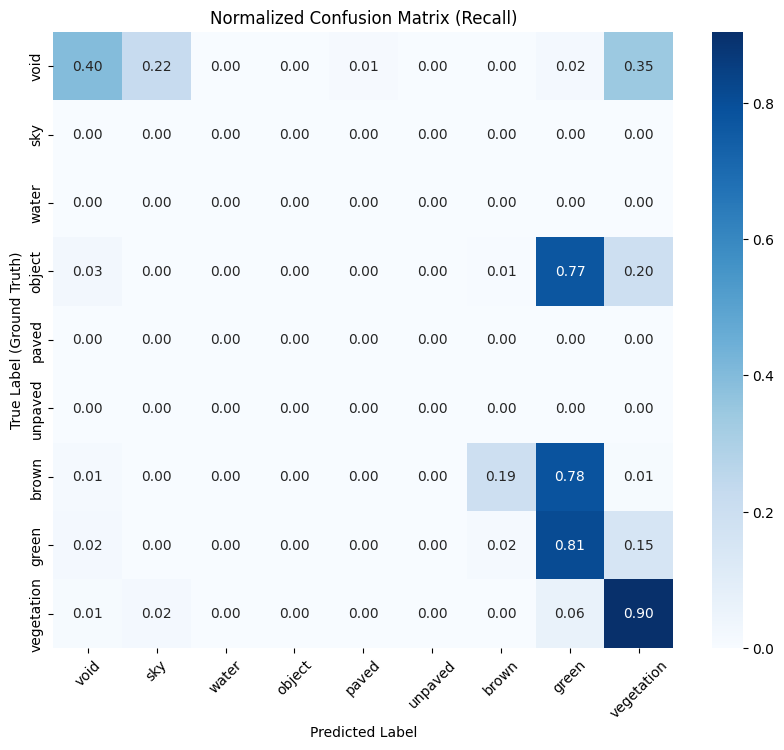

In [7]:
# ================= 配置 =================
# 必须与之前的 Mapping 设置一致
EVAL_START_IDX = START_FRAME_IDX
EVAL_NUM_FRAMES = NUM_FRAMES
EVAL_SEARCH_RADIUS = 0.8  # 匹配半径(米)，如果有些许漂移可适当调大到 0.8 或 1.0

# 1. 准备 GT 数据
print("=== 步骤 1: 准备 Ground Truth 数据 ===")
gt_points_all, gt_labels_all = accumulate_gt_map(
    start_idx=EVAL_START_IDX, 
    num_frames=EVAL_NUM_FRAMES, 
    poses=all_poses, 
    root_dir=RELLIS_ROOT, 
    seq_id=SEQ_ID,
    stride=1 # 评估时建议加载每一帧的 GT 以获得最密集的参考
)



# ================= 4. 执行新版评估 =================
if 'gt_points_all' in locals() and 'global_points' in locals():
    print("\n=== 步骤 3: 全面评估 (Comprehensive Evaluation) ===")
    
    # 确保标签是 int 类型
    global_labels_int = global_labels.astype(int)
    
    results = evaluate_map_comprehensive(
        pred_points=global_points, 
        pred_labels=global_labels_int, 
        gt_points=gt_points_all, 
        gt_labels=gt_labels_all,
        search_radius=EVAL_SEARCH_RADIUS
    )
    
    print("\n" + "="*60)
    print(f"评估详细报告 (Frames {EVAL_START_IDX}-{EVAL_START_IDX+EVAL_NUM_FRAMES})")
    print("="*60)
    print(results["DataFrame"].to_string(index=False))
    print("-" * 60)
    print(f"Global Accuracy : {results['GlobalAcc']:.4f}")
    print(f"Mean IoU        : {results['mIoU']:.4f}")
    print(f"Mean Accuracy   : {results['mAcc']:.4f}  <-- 关注这个! 若低说明小类由于不平衡被牺牲了")
    print(f"Mean F1-Score   : {results['mF1']:.4f}")
    print("="*60)
    
    # 绘制混淆矩阵
    print("\n正在绘制混淆矩阵热力图 (Row-Normalized: 显示真实类别的预测分布)...")
    plot_confusion_matrix(results["ConfusionMatrix"], CLASS_NAMES_9, normalize=True, title='Normalized Confusion Matrix (Recall)')

else:
    print("错误: 请先运行步骤 1 和 2 加载数据。")